In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2001 统计分析

In [2]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_01(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata01 = pd.read_csv("perlist01_h.csv")
    f = perdata01['f']
    per = perdata01['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata01)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [3]:
m01=Minuit(twi_minus_loglikelihood_01,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-1),limit_alpha_H=(1.0,5.0),limit_poisson=(0,3),
         errordef=1)

m01.migrad()

pprint(m01.fval)

FCN = 2305.30194657733 
 TOTAL NCALL = 257 
 NCALLS = 257 
 
 
 EDM = 5.9079118078369515e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-2.16391,0.110971,,,-3,-1,No
1,log_f_b,-3.14755,0.145005,,,-5,-1,No
2,alpha_H,3.25589,1.03899,,,1,5,No
3,poisson,1.12074,0.0620745,,,0,3,No


2305.30194657733


In [4]:
perdata01 = pd.read_csv("perlist01_h.csv")
f_01 = perdata01['f']
per_01 = perdata01['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m01.values[0],m01.values[1],m01.values[2],m01.values[3]

model_01 = []
R_obs_01 = []
T_SSE_obs_01 = 0
f_length_01 = len(f_01)
for i in range(f_length_01):
    model_01.append(((f_01[i]**(-alpha_L))/(1+(f_01[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_01.append(2*per_01[i]/model_01[i])
    T_SSE_obs_01 += (((per_01[i]-model_01[i])/model_01[i])**2)
    
# 两个统计量
T_R_obs_01 = max(R_obs_01)
print ("T_R =", T_R_obs_01)
print ("T_SSE =", T_SSE_obs_01)

T_R = 12.835528193599455
T_SSE = 788.0697883769981


In [5]:
# 5000条光变曲线

df = 0.01/f_length_01
N = 2*f_length_01
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_01]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_01):
        R_simu.append(2*per_simu[i]/model_01[i])
        T_SSE_simu += (((per_simu[i]-model_01[i])/model_01[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_01:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_01:
        n_TSSE += 1

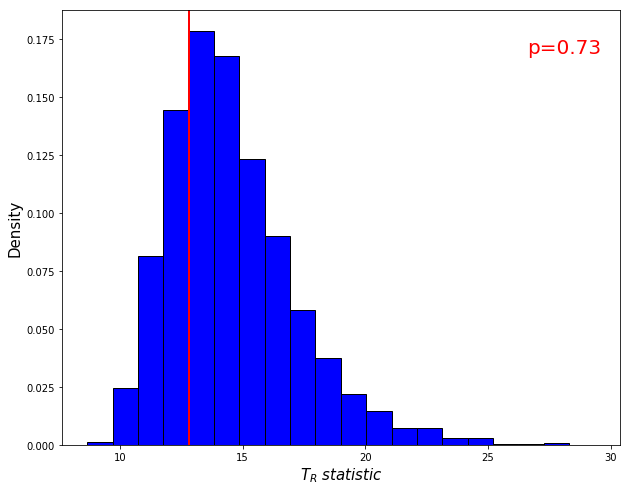

In [6]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_01, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

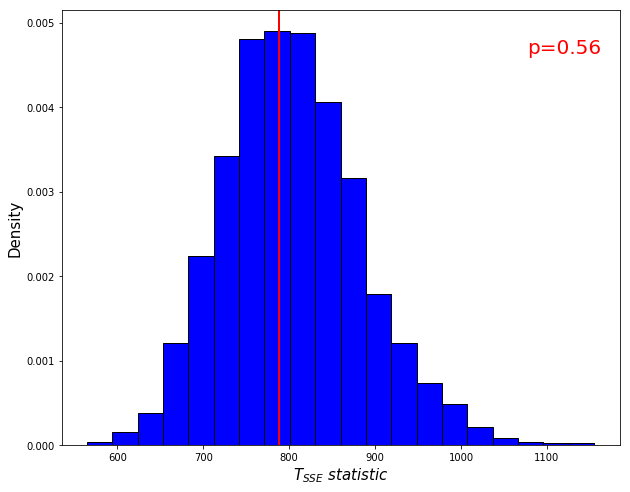

In [7]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_01, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2005(1) 统计分析

In [8]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_051(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata051 = pd.read_csv("perlist051_h.csv")
    f = perdata051['f']
    per = perdata051['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata051)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [9]:
m051=Minuit(twi_minus_loglikelihood_051,log_A=-1,log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=5,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-7,0), limit_log_f_b=(-10,-1),limit_alpha_H=(1.0,8.0),limit_poisson=(0,10),
         errordef=1)

m051.migrad()

pprint(m051.fval)

FCN = 3549.746112315071 
 TOTAL NCALL = 563 
 NCALLS = 563 
 
 
 EDM = 0.00013220743369724404 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-0.00221113,0.910316,,,-7,0,No
1,log_f_b,-7.58602,1.01874,,,-10,-1,No
2,alpha_H,1.55188,0.135653,,,1,8,No
3,poisson,3.57095,0.196243,,,0,10,No


3549.746112315071


In [10]:
perdata051 = pd.read_csv("perlist051_h.csv")
f_051 = perdata051['f']
per_051 = perdata051['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m051.values[0],m051.values[1],m051.values[2],m051.values[3]

model_051 = []
R_obs_051 = []
T_SSE_obs_051 = 0
f_length_051 = len(f_051)
for i in range(f_length_051):
    model_051.append(((f_051[i]**(-alpha_L))/(1+(f_051[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_051.append(2*per_051[i]/model_051[i])
    T_SSE_obs_051 += (((per_051[i]-model_051[i])/model_051[i])**2)
    
# 两个统计量
T_R_obs_051 = max(R_obs_051)
print ("T_R =", T_R_obs_051)
print ("T_SSE =", T_SSE_obs_051)

T_R = 13.832342321911739
T_SSE = 689.1063046038848


In [11]:
# 5000条光变曲线

df = 0.01/f_length_051
N = 2*f_length_051
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_051]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_051):
        R_simu.append(2*per_simu[i]/model_051[i])
        T_SSE_simu += (((per_simu[i]-model_051[i])/model_051[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_051:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_051:
        n_TSSE += 1

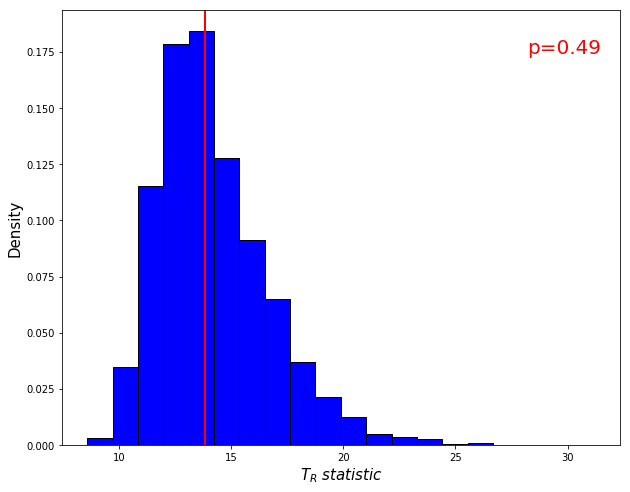

In [12]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_051, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

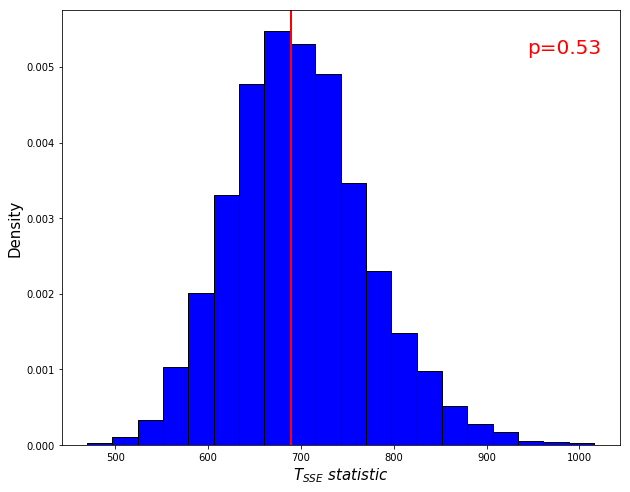

In [13]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_051, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2005(4) 统计分析

In [14]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_054(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata054 = pd.read_csv("perlist054_h.csv")
    f = perdata054['f']
    per = perdata054['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata054)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [15]:
m054=Minuit(twi_minus_loglikelihood_054,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-1),limit_alpha_H=(1.0,7.0),limit_poisson=(0,3),
         errordef=1)

m054.migrad()

pprint(m054.fval)

FCN = 2315.1170368584185 
 TOTAL NCALL = 247 
 NCALLS = 247 
 
 
 EDM = 6.144623845841016e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-2.18896,0.0846098,,,-3,-1,No
1,log_f_b,-3.1835,0.0569023,,,-5,-1,No
2,alpha_H,6.22003,4.61403,,,1,7,No
3,poisson,1.54754,0.0644609,,,0,3,No


2315.1170368584185


In [16]:
perdata054 = pd.read_csv("perlist054_h.csv")
f_054 = perdata054['f']
per_054 = perdata054['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m054.values[0],m054.values[1],m054.values[2],m054.values[3]

model_054 = []
R_obs_054 = []
T_SSE_obs_054 = 0
f_length_054 = len(f_054)
for i in range(f_length_054):
    model_054.append(((f_054[i]**(-alpha_L))/(1+(f_054[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_054.append(2*per_054[i]/model_054[i])
    T_SSE_obs_054 += (((per_054[i]-model_054[i])/model_054[i])**2)
    
# 两个统计量
T_R_obs_054 = max(R_obs_054)
print ("T_R =", T_R_obs_054)
print ("T_SSE =", T_SSE_obs_054)

T_R = 14.42977649963508
T_SSE = 677.5923194892223


In [17]:
# 5000条光变曲线

df = 0.01/f_length_054
N = 2*f_length_054
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_054]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_054):
        R_simu.append(2*per_simu[i]/model_054[i])
        T_SSE_simu += (((per_simu[i]-model_054[i])/model_054[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_054:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_054:
        n_TSSE += 1

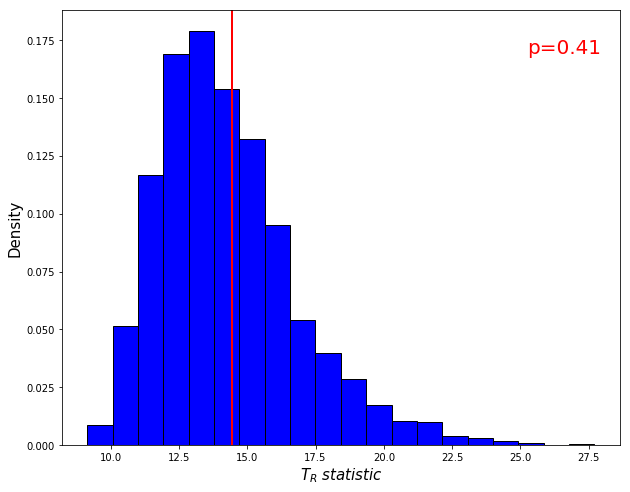

In [18]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_054, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

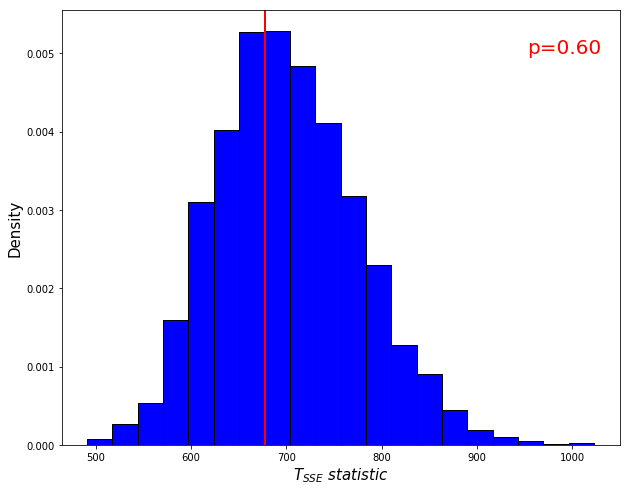

In [19]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_054, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 综合结果

In [11]:
data01 = pd.read_csv("energy_mrk766_01.csv")  
x01 = data01['x']
y01 = data01['y']
xerr01 = data01['xerr']
yerr01 = data01['yerr']

data051 = pd.read_csv("energy_mrk766_051.csv")  
x051 = data051['x']
y051 = data051['y']
xerr051 = data051['xerr']
yerr051 = data051['yerr']

data054 = pd.read_csv("energy_mrk766_054.csv")  
x054 = data054['x']
y054 = data054['y']
xerr054 = data054['xerr']
yerr054 = data054['yerr']

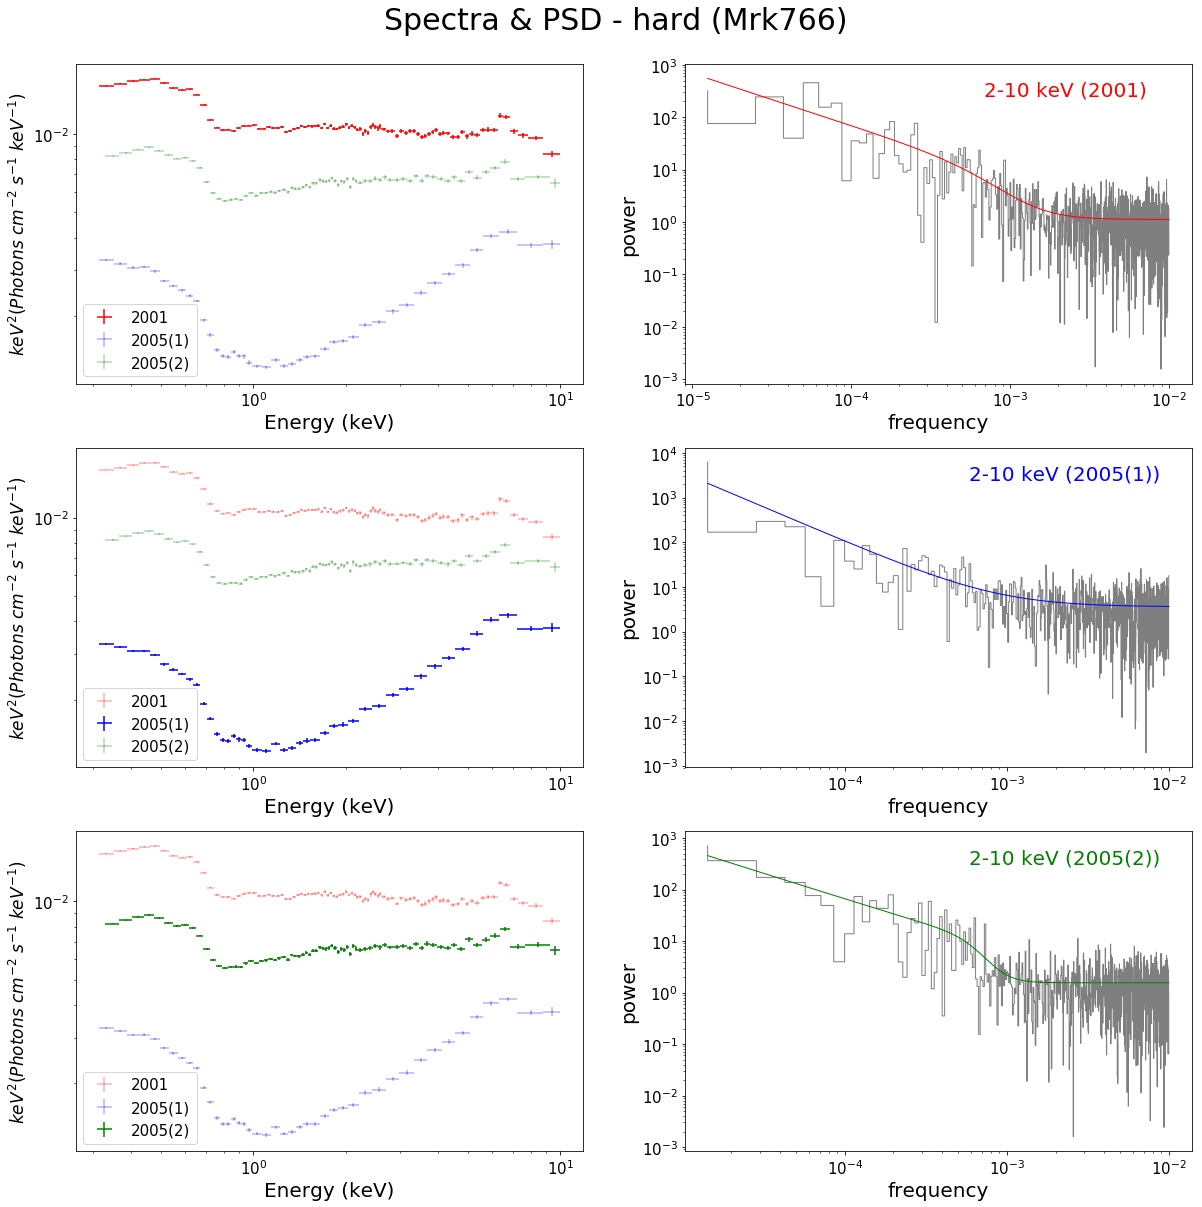

In [12]:
fig= plt.figure(figsize=(20,20))
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)


ax1.loglog()
ax1.errorbar(x01, y01, yerr=yerr01, xerr=xerr01, fmt=',r', label='2001')
ax1.errorbar(x051, y051, yerr=yerr051, xerr=xerr051, fmt=',b', alpha=0.3, label='2005(1)')
ax1.errorbar(x054, y054, yerr=yerr054, xerr=xerr054, fmt=',g', alpha=0.3, label='2005(2)')
ax1.set_xlabel("Energy (keV)",fontsize=20)
ax1.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)

ax3.loglog()
ax3.errorbar(x01, y01, yerr=yerr01, xerr=xerr01, fmt=',r', alpha=0.3, label='2001')
ax3.errorbar(x051, y051, yerr=yerr051, xerr=xerr051, fmt=',b', label='2005(1)')
ax3.errorbar(x054, y054, yerr=yerr054, xerr=xerr054, fmt=',g', alpha=0.3, label='2005(2)')
ax3.set_xlabel("Energy (keV)",fontsize=20)
ax3.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax3.legend(fontsize=15)
ax3.tick_params(labelsize=15)

ax5.loglog()
ax5.errorbar(x01, y01, yerr=yerr01, xerr=xerr01, fmt=',r', alpha=0.3, label='2001')
ax5.errorbar(x051, y051, yerr=yerr051, xerr=xerr051, fmt=',b', alpha=0.3, label='2005(1)')
ax5.errorbar(x054, y054, yerr=yerr054, xerr=xerr054, fmt=',g', label='2005(2)')
ax5.set_xlabel("Energy (keV)",fontsize=20)
ax5.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax5.legend(fontsize=15)
ax5.tick_params(labelsize=15)


ax2.loglog()
ax2.step(f_01, per_01, color="k", alpha=0.5, linewidth=1)
ax2.plot(f_01, model_01, color="r", linewidth=1)
ax2.set_xlabel("frequency",fontsize=20)
ax2.set_ylabel("power",fontsize=20)
ax2.text(0.75,0.9,"2-10 keV (2001)",color='r',ha='center',transform=ax2.transAxes,fontsize=20)
ax2.tick_params(labelsize=15)

ax4.loglog()
ax4.step(f_051, per_051, color="k", alpha=0.5, linewidth=1)
ax4.plot(f_051, model_051, color="b", linewidth=1)
ax4.set_xlabel("frequency",fontsize=20)
ax4.set_ylabel("power",fontsize=20)
ax4.text(0.75,-0.3,"2-10 keV (2005(1))",color='b',ha='center',transform=ax2.transAxes,fontsize=20)
ax4.tick_params(labelsize=15)

ax6.loglog()
ax6.step(f_054, per_054, color="k", alpha=0.5, linewidth=1)
ax6.plot(f_054, model_054, color="g", linewidth=1)
ax6.set_xlabel("frequency",fontsize=20)
ax6.set_ylabel("power",fontsize=20)
ax6.text(0.75,-1.5,"2-10 keV (2005(2))",color='g',ha='center',transform=ax2.transAxes,fontsize=20)
ax6.tick_params(labelsize=15)

plt.suptitle("Spectra & PSD - hard (Mrk766)", x=0.5, y=0.92, fontsize=30)
plt.show()

## 2001 MCMC

In [13]:
# 均匀先验

def lnprior_01(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < -1 and -5 < log_f_b < -1 and 1.0 < alpha_H < 8.0 and 0.0 < poisson < 2.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_01(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_01(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_01(log_A,log_f_b,alpha_H,poisson))

In [14]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m01.values[0],m01.values[1],m01.values[2],m01.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_01)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1164.0 seconds


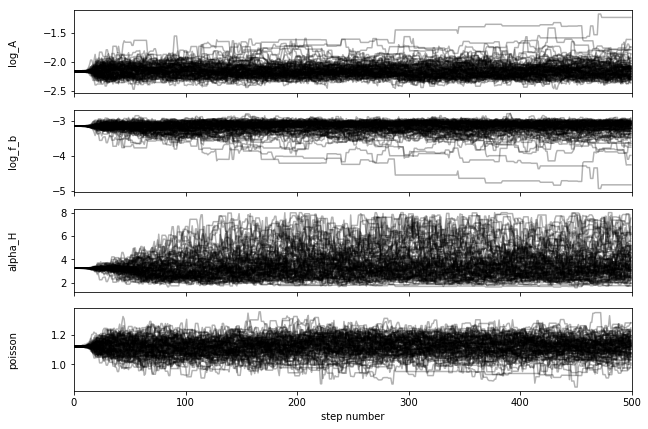

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [16]:
print ("Parameters (2001)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2001)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

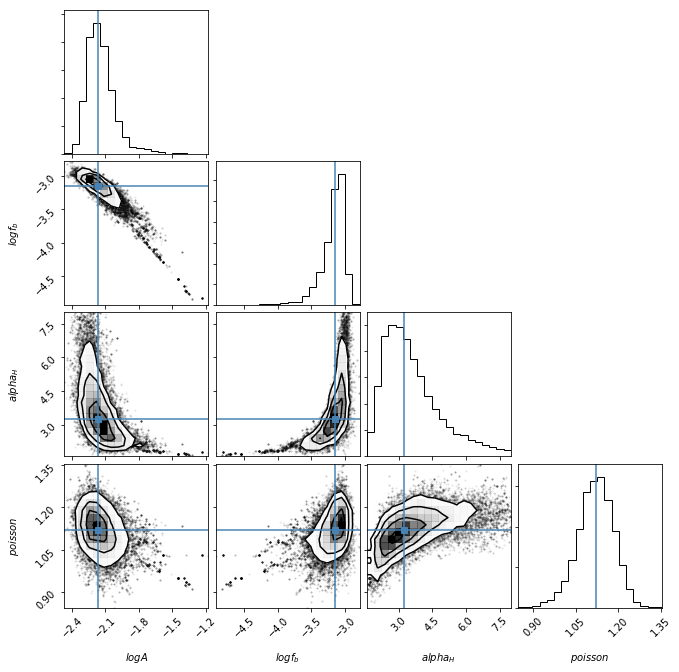

In [17]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m01.values[0], m01.values[1], m01.values[2], m01.values[3]])

## 2005(1) MCMC

In [53]:
# 均匀先验

def lnprior_051(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -5 < log_A < 15 and -30 < log_f_b < 0 and 1.0 < alpha_H < 5.0 and 0.0 < poisson < 7.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_051(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_051(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_051(log_A,log_f_b,alpha_H,poisson))

In [54]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m051.values[0],m051.values[1],m051.values[2],m051.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_051)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 966.4 seconds


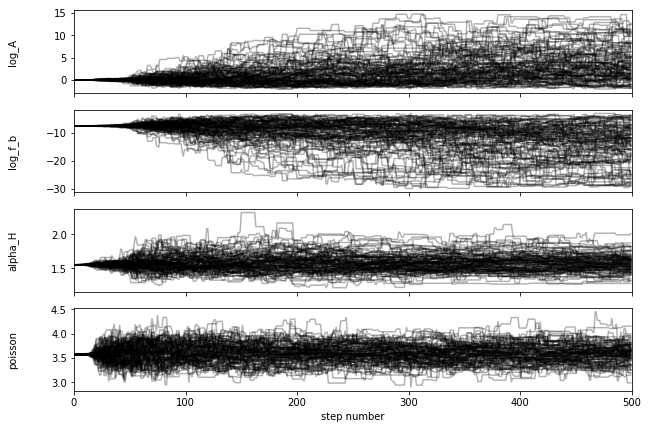

In [55]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [56]:
print ("Parameters (2005(1))")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2005(1))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

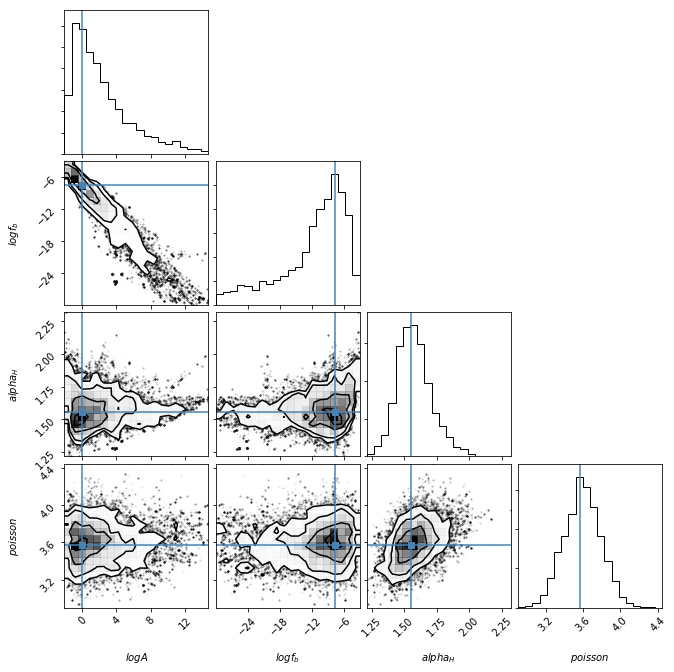

In [57]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m051.values[0], m051.values[1], m051.values[2], m051.values[3]])

## 2005(4) MCMC

In [43]:
# 均匀先验

def lnprior_054(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < 1 and -5 < log_f_b < -1 and 1.0 < alpha_H < 25.0 and 0.0 < poisson < 4.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_054(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_054(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_054(log_A,log_f_b,alpha_H,poisson))

In [44]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m054.values[0],m054.values[1],m054.values[2],m054.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_054)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1040.1 seconds


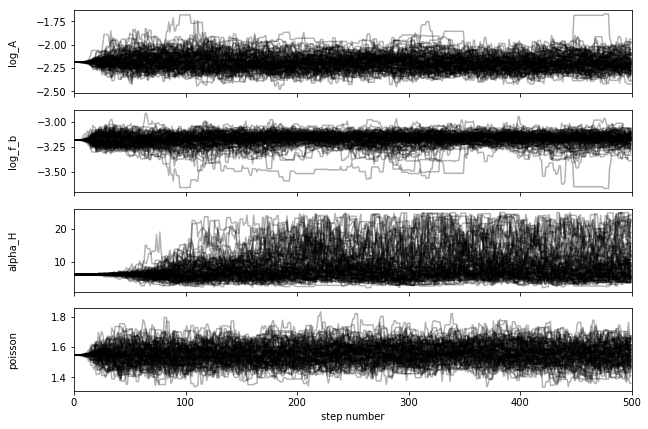

In [45]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [46]:
print ("Parameters (2005(2))")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2005(2))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

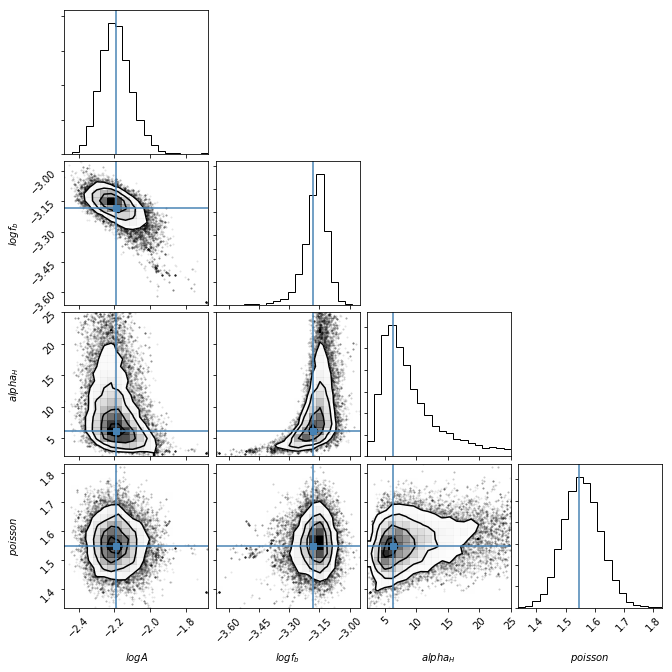

In [47]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m054.values[0], m054.values[1], m054.values[2], m054.values[3]])